In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

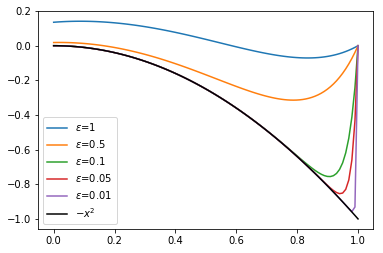

In [2]:
x = np.linspace(0,1,100)
x = np.array([x]).T

def solution(x,e):
    return np.exp((x*x+x-2)/e) - x**2

plt.plot(x,solution(x,1),label='$\epsilon$=1')
plt.plot(x,solution(x,0.5),label='$\epsilon$=0.5')
plt.plot(x,solution(x,0.1),label='$\epsilon$=0.1')
plt.plot(x,solution(x,0.05),label='$\epsilon$=0.05')
plt.plot(x,solution(x,0.01),label='$\epsilon$=0.01')
plt.plot(x,-x**2,label='$-x^2$',c='k')
plt.legend()
plt.show()

e = 0.01
y = solution(x,e)
x_i = np.array([[0]],dtype='float')
y_i = np.array([[np.exp(-2/e)]],dtype='float')
x_f = lhs(1, 10000)
x_i = tf.constant(x_i,dtype=tf.float32)
x_f = tf.constant(x_f,dtype=tf.float32)
y_i = tf.constant(y_i,dtype=tf.float32)
x = tf.constant(x,dtype=tf.float32)
y = tf.constant(y,dtype=tf.float32)

In [3]:
def PINN(model):
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)
    count = 0
    idx = []
    part = []
    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n
    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    @tf.function
    def f(params_1d):
        with tf.GradientTape() as tape:
            tape.watch(model.trainable_variables)
            assign_new_model_parameters(params_1d)
            loss_value = loss_PINN(model)
        grads = tape.gradient(loss_value, model.trainable_variables)
        newgrads = tf.dynamic_stitch(idx, grads)
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])
        return loss_value, newgrads
    
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

In [4]:
def loss_PINN(model):
    with tf.GradientTape() as tape:
        tape.watch(x_f)
        y_pred_f = model.call(x_f)
        y_x = tape.gradient(y_pred_f,x_f)
    y_pred_i = model.call(x_i)
    F = e*y_x - (2*x_f+1)*tf.exp((x_f**2+x_f-2)/e) + 2*e*x_f
    loss = tf.reduce_mean(tf.square(y_i-y_pred_i)) + tf.reduce_mean(tf.square(F))
    return loss

model_pinn = keras.models.Sequential([
    keras.layers.Dense(2, activation='tanh'),
    keras.layers.Dense(10, activation='tanh'),
    keras.layers.Dense(1)
])
model_pinn.call(x_f)

pinn = PINN(model_pinn)
init_pinn_params = tf.dynamic_stitch(pinn.idx, model_pinn.trainable_variables)
final_pinn_params = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=pinn, initial_position=init_pinn_params, max_iterations=1000)
pinn_pred = model_pinn.predict(x)
res_pinn = y - pinn_pred

Iter: 1 loss: 0.0147237564
Iter: 2 loss: 0.0147237191
Iter: 3 loss: 0.0147235794
Iter: 4 loss: 0.0147231603
Iter: 5 loss: 0.0147271715
Iter: 6 loss: 0.0147231156
Iter: 7 loss: 0.0147218183
Iter: 8 loss: 0.0147167761
Iter: 9 loss: 0.0147367595
Iter: 10 loss: 0.0147129828
Iter: 11 loss: 0.0149719883
Iter: 12 loss: 0.0147118522
Iter: 13 loss: 0.0147135006
Iter: 14 loss: 0.0147093721
Iter: 15 loss: 0.014706756
Iter: 16 loss: 0.0147067206
Iter: 17 loss: 0.0147030046
Iter: 18 loss: 0.0146959135
Iter: 19 loss: 0.0161779895
Iter: 20 loss: 0.0146958837
Iter: 21 loss: 0.0146970749
Iter: 22 loss: 0.0146948015
Iter: 23 loss: 0.0146931922
Iter: 24 loss: 0.0147190131
Iter: 25 loss: 0.0146929733
Iter: 26 loss: 0.0146924276
Iter: 27 loss: 0.0146923
Iter: 28 loss: 0.0146917515
Iter: 29 loss: 0.014692327
Iter: 30 loss: 0.0146916248
Iter: 31 loss: 0.0146916006
Iter: 32 loss: 0.0146916015
Iter: 33 loss: 0.0146915894
Iter: 34 loss: 0.0146915875
Iter: 35 loss: 0.0146914888
Iter: 36 loss: 0.0146911014
Iter: 

epsilon = 0.01


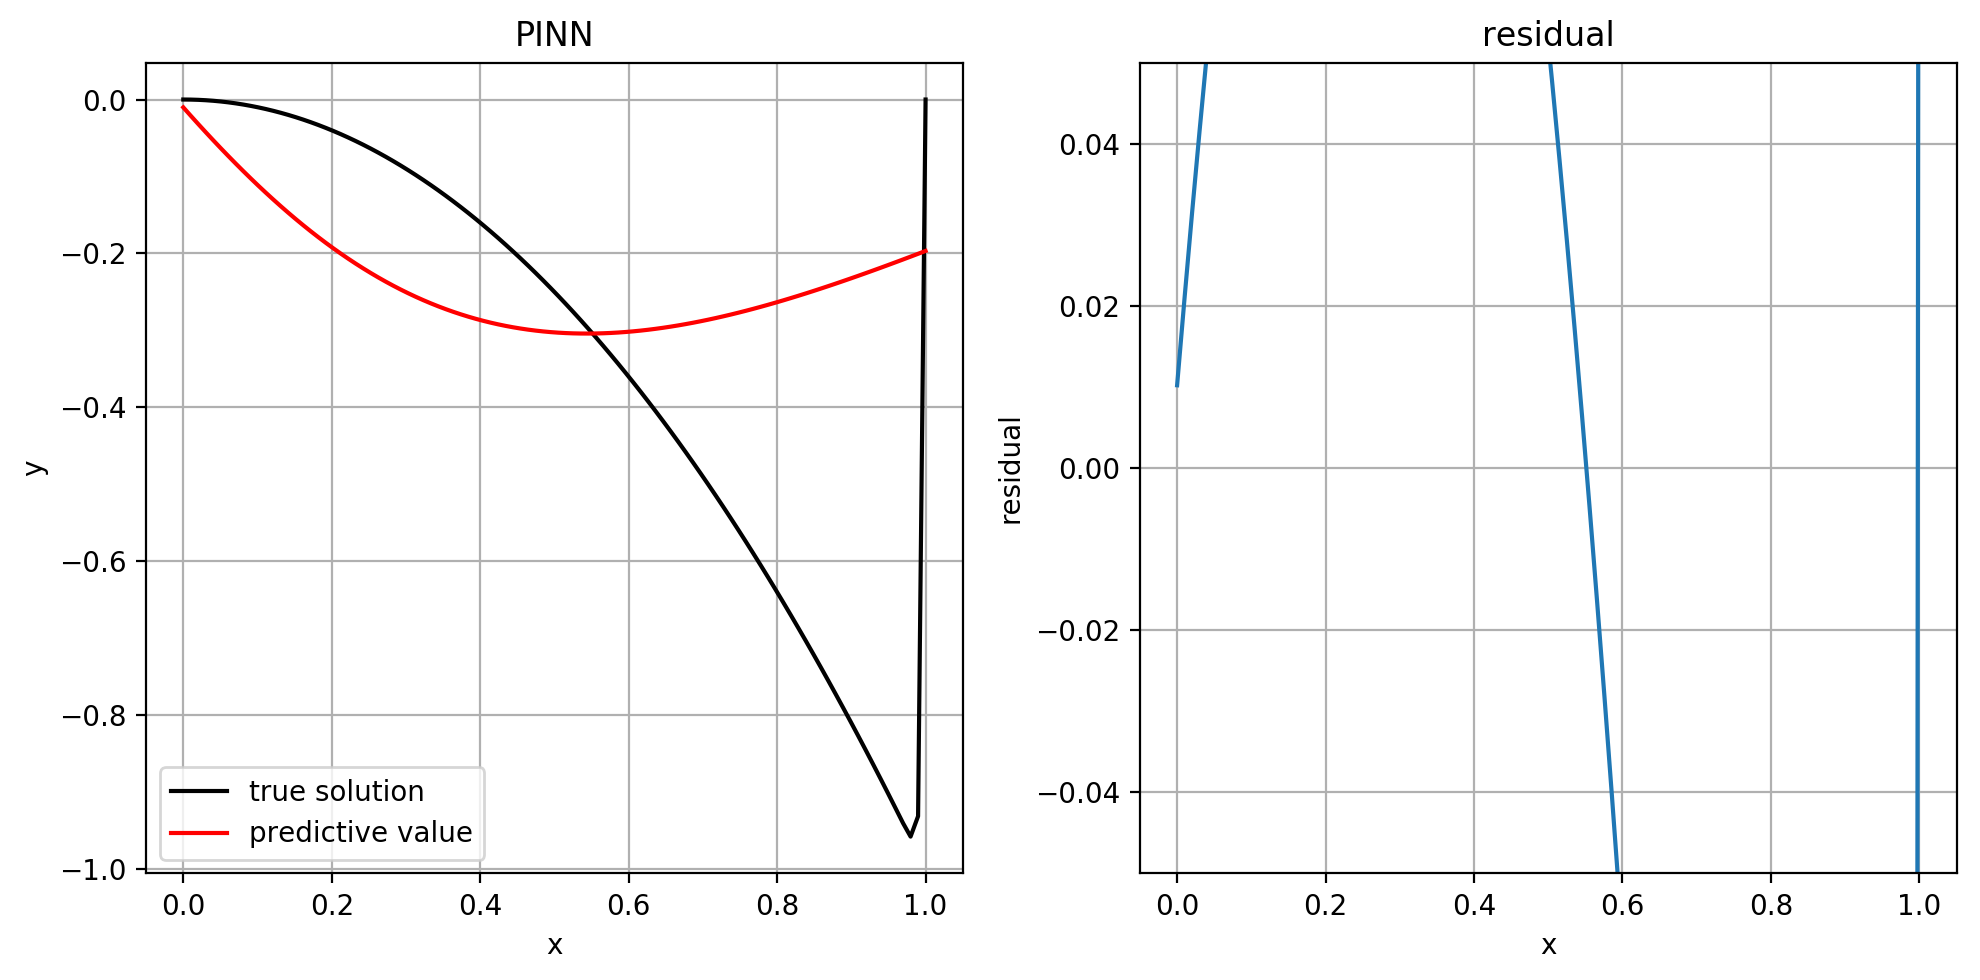

In [5]:
print('epsilon =',e)
plt.figure(figsize=(10,5),dpi=200)
plt.subplot(1,2,1)
plt.title('PINN')
plt.plot(x,y,color='k',label='true solution')
plt.plot(x,pinn_pred,color='r',label='predictive value')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.title('residual')
plt.plot(x,res_pinn)
plt.ylim((-0.05,0.05))
plt.grid()
plt.xlabel('x')
plt.ylabel('residual')
plt.tight_layout()
plt.savefig('D:\\paper_tpinn\\fig_TPINN\\failure2_2.png')
plt.show()